# Estimating Covariance and Expected Returns

We've backtested CW and EW Portfolios and they each have unique positions in industrial implementations.

CapWeighted portfolios are the overall average and hence the de-facto industry standard. They are very inexpensive to implement and feature very low turnover. In many ways, they are the default go-to implementation choice for many investors.

However, we've seen that they suffer from some disadvantages, so there is some room for improvement.

EW are the most obvious improvement because they are the only other technique we are going to look at (other than CW) that requires no estimation of either covariance or expected returns. We've already backtested those and we've seen how easy they are to build.

We'll now move on the more sophisticated portfolio construction techniques, but they will get us involved in the estimation game, something we've avoided so far ... so let's start by pulling in the data we need and start with the CW and EW portfolios, since they are the baseline portfolios.

In [1]:
import numpy as np
import pandas as pd

import edhec_risk_kit_205 as erk

%load_ext autoreload
%autoreload 2
inds = ['Food', 'Beer', 'Smoke', 'Games', 'Books', 'Hshld', 'Clths', 'Hlth',
       'Chems', 'Txtls', 'Cnstr', 'Steel', 'FabPr', 'ElcEq', 'Autos', 'Carry',
       'Mines', 'Coal', 'Oil', 'Util', 'Telcm', 'Servs', 'BusEq', 'Paper',
       'Trans', 'Whlsl', 'Rtail', 'Meals', 'Fin', 'Other']
#inds=['Beer', 'Hlth', 'Fin','Rtail','Whlsl']
ind_rets = erk.get_ind_returns(weighting="vw", n_inds=30)["1997":]
ind_mcap = erk.get_ind_market_caps(30, weights=True)["1997":]

In [2]:
ind_rets.shape

(264, 30)

In [3]:
def weight_ew(r, cap_weights=None, max_cw_mult=None, microcap_threshold=None, **kwargs):
    """
    Returns the weights of the EW portfolio based on the asset returns "r" 
    as a DataFrame
    If supplied a set of capweights and a capweight tether, 
    it is applied and reweighted 
    """
    n = len(r.columns)
    ew = pd.Series(1/n, index=r.columns)
    if cap_weights is not None:
        cw = cap_weights.loc[r.index[0]] # starting cap weight
        if microcap_threshold is not None and microcap_threshold > 0:
            microcap = cw < microcap_threshold
            ew[microcap] = 0
            ew = ew/ew.sum()
        if max_cw_mult is not None and max_cw_mult > 0:
            ew = np.minimum(ew, cw*max_cw_mult)
            ew = ew/ew.sum()
    return ew

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
EW,0.077614,0.158685,-0.538531,5.317042,0.072485,0.106220,0.291838,-0.53298
CW,0.065196,0.151478,-0.556621,4.249894,0.071076,0.098531,0.225949,-0.51899


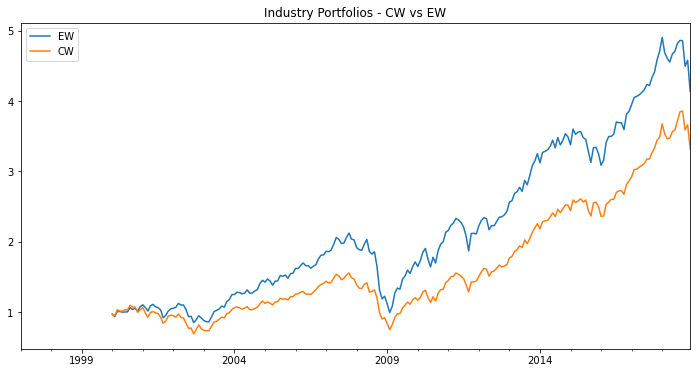

In [15]:
ewr = erk.backtest_ws(ind_rets, estimation_window=36, weighting=erk.weight_ew)
cwr = erk.backtest_ws(ind_rets, estimation_window=36, weighting=erk.weight_cw, cap_weights=ind_mcap)
btr = pd.DataFrame({"EW": ewr, "CW": cwr})
(1+btr).cumprod().plot(figsize=(12,6), title="Industry Portfolios - CW vs EW")
erk.summary_stats(btr.dropna())

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
EW,0.084304,0.158993,-0.584382,5.610461,0.072377,0.105969,0.332227,-0.532980
CW,0.076016,0.149290,-0.648351,4.643142,0.069809,0.099167,0.299811,-0.518990
EWTR,0.085243,0.139920,-0.744679,5.111126,0.065003,0.094220,0.384101,-0.491242


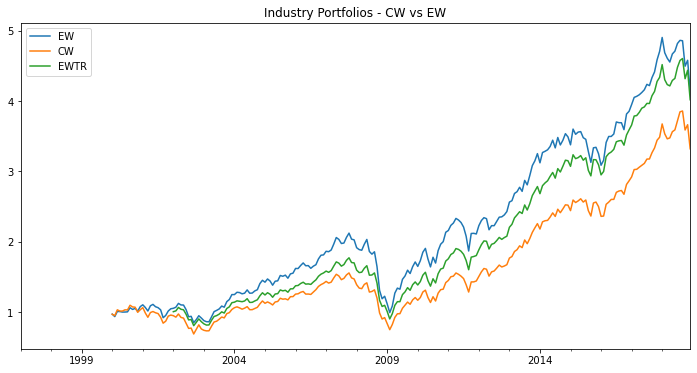

In [5]:
ewr = erk.backtest_ws(ind_rets, estimation_window=36, weighting=erk.weight_ew)
cwr = erk.backtest_ws(ind_rets, estimation_window=36, weighting=erk.weight_cw, cap_weights=ind_mcap)
ewtr = erk.backtest_ws(ind_rets, cap_weights=ind_mcap, max_cw_mult=2, microcap_threshold=0.01)
btr = pd.DataFrame({"EW": ewr, "CW": cwr, "EWTR": ewtr})
(1+btr).cumprod().plot(figsize=(12,6), title="Industry Portfolios - CW vs EW")
erk.summary_stats(btr.dropna())

In [6]:
erk.tracking_error(ewr, cwr),erk.tracking_error(ewtr, cwr)

(0.18752094143646486, 0.11056486269378529)

# Building the Global Minimum Variance Portfolio

We've previously written the code (in MOOC 1) to build the GMV portfolio, given the covariance. Let's start with just that:


In [7]:
def sample_cov(r, **kwargs):
    """
    Returns the sample covariance of the supplied returns
    """
    return r.cov()

def weight_gmv(r, cov_estimator=sample_cov, **kwargs):
    """
    Produces the weights of the GMV portfolio given a covariance matrix of the returns 
    """
    est_cov = cov_estimator(r, **kwargs)
    return erk.gmv(est_cov)


Now, let's run this new backtest. This may take a fair amount of time to run, so be patient - we are running a backtest over nearly 50 years and both optimizing and rebalancing on a monthly basis ... this will take a while!

In [ ]:
mv_s_r = erk.backtest_ws(ind_rets, estimation_window=36, weighting=weight_gmv, cov_estimator=sample_cov)
btr = pd.DataFrame({"EW": ewr, "CW": cwr, "GMV-Sample": mv_s_r})
(1+btr).cumprod().plot(figsize=(12,6), title="Industry Portfolios")
erk.summary_stats(btr.dropna())

Now, let's try a new estimator - Constant Correlation. The idea is simple, take the sample correlation matrix, compute the average correlation and then reconstruct the covariance matrix. The relation between correlations $\rho$ and covariance $\sigma$ is given by:

$$ \rho_{ij} = \frac{ \sigma_{ij} } { \sqrt{ \sigma_{ii}  \sigma_{jj} } } $$


In [5]:
#import statsmodels.stats.moment_helpers as mh
def cc_cov(r, **kwargs):
    """
    Estimates a covariance matrix by using the Elton/Gruber Constant Correlation model
    """
    rhos = r.corr()
    n = rhos.shape[0]
    # this is a symmetric matrix with diagonals all 1 - so the mean correlation is ...
    rho_bar = (rhos.values.sum()-n)/(n*(n-1))
    ccor = np.full_like(rhos, rho_bar)
    np.fill_diagonal(ccor, 1.)
    sd = r.std()
    ccov = ccor * np.outer(sd, sd)
#     mh.corr2cov(ccor, sd)
    return pd.DataFrame(ccov, index=r.columns, columns=r.columns)

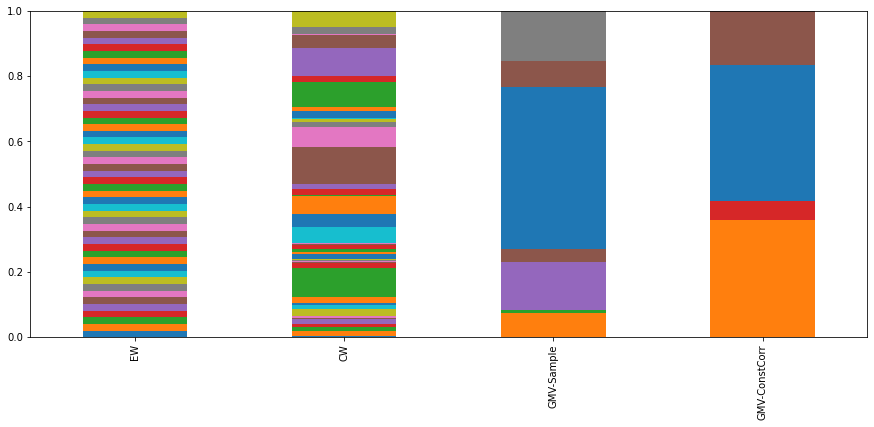

In [6]:
wts = pd.DataFrame({
    "EW": erk.weight_ew(ind_rets["2016":]),
    "CW": erk.weight_cw(ind_rets["2016":], cap_weights=ind_mcap),
    "GMV-Sample": weight_gmv(ind_rets["2016":], cov_estimator=sample_cov),
    "GMV-ConstCorr": weight_gmv(ind_rets["2016":], cov_estimator=cc_cov),
})
wts.T.plot.bar(stacked=True, figsize=(15,6), legend=False);


,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
EW,0.148302,0.192188,-0.307376,7.206041,0.078070,0.120539,0.598904,-0.598060
CW,0.143031,0.196331,-0.177721,6.570301,0.079071,0.123110,0.560123,-0.590479
GMV-Sample,0.159645,0.140424,-0.209714,7.914586,0.051740,0.084915,0.898491,-0.509041
GMV-CC,0.149232,0.140178,-0.665695,9.414711,0.056091,0.089713,0.827742,-0.595778


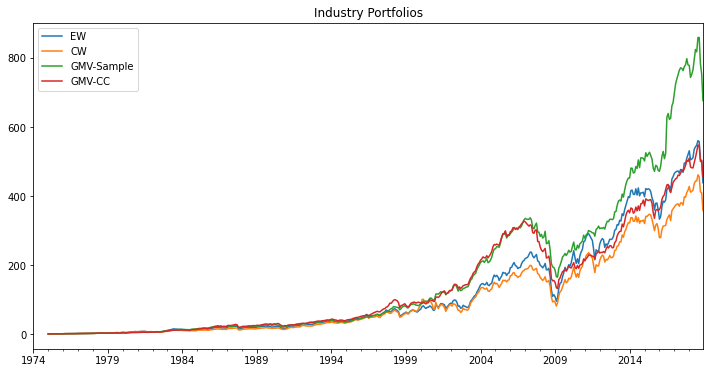

In [7]:
mv_cc_r = erk.backtest_ws(ind_rets, estimation_window=12, weighting=weight_gmv, cov_estimator=cc_cov)
btr = pd.DataFrame({"EW": ewr, "CW": cwr, "GMV-Sample": mv_s_r, "GMV-CC": mv_cc_r})
(1+btr).cumprod().plot(figsize=(12,6), title="Industry Portfolios")
erk.summary_stats(btr.dropna())

### Statistical Shrinkage

We can mix the model and sample estimates by choosing a shrinkage parameter. You can either let the numbers dictate an optimal shrinkage value for $\delta$ although in practice many practiotioners choose $0.5$. Let's implement a simple shrinkage based covariance estimator that shrinks towards the Constant Correlation estimate.

In [8]:
def shrinkage_cov(r, delta=0.5, **kwargs):
    """
    Covariance estimator that shrinks between the Sample Covariance and the Constant Correlation Estimators
    """
    prior = cc_cov(r, **kwargs)
    sample = sample_cov(r, **kwargs)
    return delta*prior + (1-delta)*sample


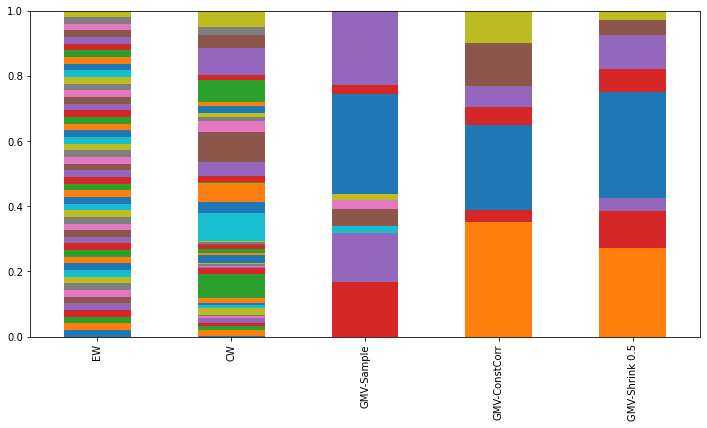

In [9]:
wts = pd.DataFrame({
    "EW": erk.weight_ew(ind_rets["2013":]),
    "CW": erk.weight_cw(ind_rets["2013":], cap_weights=ind_mcap),
    "GMV-Sample": weight_gmv(ind_rets["2013":], cov_estimator=sample_cov),
    "GMV-ConstCorr": weight_gmv(ind_rets["2013":], cov_estimator=cc_cov),
    "GMV-Shrink 0.5": weight_gmv(ind_rets["2013":], cov_estimator=shrinkage_cov),
})
wts.T.plot.bar(stacked=True, figsize=(12,6), legend=False);


,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
EW,0.148302,0.192188,-0.307376,7.206041,0.078070,0.120539,0.598904,-0.598060
CW,0.143031,0.196331,-0.177721,6.570301,0.079071,0.123110,0.560123,-0.590479
GMV-Sample,0.159645,0.140424,-0.209714,7.914586,0.051740,0.084915,0.898491,-0.509041
GMV-CC,0.149232,0.140178,-0.665695,9.414711,0.056091,0.089713,0.827742,-0.595778
GMV-Shrink 0.5,0.152924,0.136368,-0.517532,8.479728,0.053221,0.086786,0.877244,-0.554248


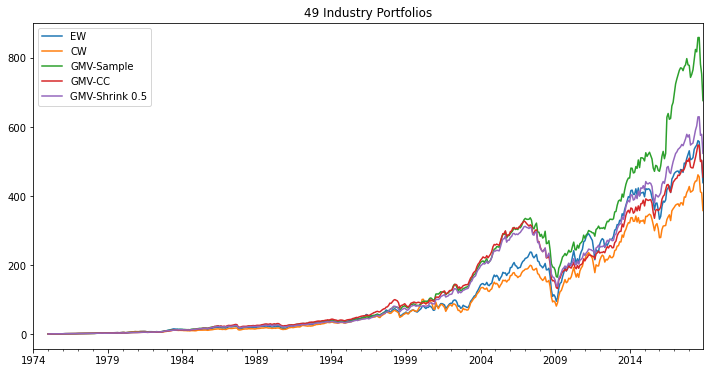

In [10]:
mv_sh_r = erk.backtest_ws(ind_rets, estimation_window=12, weighting=weight_gmv, cov_estimator=shrinkage_cov, delta=0.5)
btr = pd.DataFrame({"EW": ewr, "CW": cwr, "GMV-Sample": mv_s_r, "GMV-CC": mv_cc_r, 'GMV-Shrink 0.5': mv_sh_r})
(1+btr).cumprod().plot(figsize=(12,6), title="49 Industry Portfolios")
erk.summary_stats(btr.dropna())